In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
print(tf.__version__)

2.2.0


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [5]:
from pae.model_tf2 import get_prior, get_posterior, get_likelihood

In [6]:
import pae.create_datasets_tf2 as crd

In [7]:
param_file = 'params_mnist_-1_10_vae10_AE_test_full_sigma'

In [8]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

In [9]:
params   = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [10]:
params['plot_dir']= os.path.join(PROJECT_PATH,'plots')

In [11]:
params['data_dir']= os.path.join('/global/cscratch1/sd/vboehm/RNF','datasets')
params['module_dir']= os.path.join('/global/cscratch1/sd/vboehm/RNF','modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma')

In [12]:
if not os.path.isdir(params['plot_dir']):
    os.makedirs(params['plot_dir'])
if not os.path.isdir(params['data_dir']):
    os.makedirs(params['data_dir'])

In [13]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'hybrid1')

In [14]:
train_input_fn, eval_input_fn = crd.build_input_fns(params,label=params['class_label'],flatten=True,num_repeat=15)

loading mnist dataset


In [15]:
tf.reset_default_graph()

traindata     = train_input_fn()
validdata     = eval_input_fn()
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)

posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params)

# inspect the model
zt    = posterior(traindata).mean()
recont = likelihood(zt).mean()

zv    = posterior(validdata).mean()
reconv = likelihood(zv).mean()


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variabl

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
if params['data_set']=='celeba':
    train_size = 162770
    val_size   = 182637-162770 
else:
    train_size = 50000
    val_size   = 10000

In [18]:
print(train_size)

50000


In [19]:
print(train_size//params['batch_size']+1)
enc_path = os.path.join('encoded/',params['data_set'],str(params['latent_size']))
print(os.path.join(params['data_dir'],enc_path))
if not os.path.isdir(os.path.join(params['data_dir'],enc_path)):
    os.makedirs(os.path.join(params['data_dir'],enc_path))

3126
/global/cscratch1/sd/vboehm/RNF/datasets/encoded/mnist/10


In [20]:
try:
    assert(False)
    z_sample = np.load(os.path.join(params['data_dir'],enc_path,'train.npy'))
except:
    z_sample=[]
    for ii in range(train_size//params['batch_size']+1):
        if ii%100==0:
            print(ii)
        z_sample+=[sess.run(zt)]
        
    z_sample = np.asarray(z_sample).reshape((-1,params['latent_size']))
    z_sample = z_sample[0:train_size]
    
    np.save(os.path.join(params['data_dir'],enc_path,'train.npy'),z_sample)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


In [21]:
try:
    assert(False)
    z_sample_valid = np.load(os.path.join(params['data_dir'],enc_path,'valid.npy'))
except:
    z_sample_valid=[]

    for ii in range(val_size//params['batch_size']+1):
        if ii%100==0:
            print(ii)
        z_sample_valid+=[sess.run(zv)]
    z_sample_valid=np.asarray(z_sample_valid).reshape((-1,params['latent_size']))
    z_sample_valid= z_sample_valid[0:val_size]
    np.save(os.path.join(params['data_dir'],enc_path,'valid.npy'),z_sample_valid)

0
100
200
300
400
500
600


In [22]:
np.amax(z_sample)
np.amax(z_sample_valid)

4.8830476

In [23]:
nvp_depth    = 12
dims         = np.asarray([10,10,10,10,10,10,8,8,8,8,4,4])
nvp_size     = np.arange(nvp_depth)
indices      = np.arange(params['latent_size'])
#permutations = [np.random.permutation(np.arange(params['latent_size'])) for ii in range(nvp_depth)]
#swapping     = np.concatenate((indices[params['latent_size']//2:params['latent_size']],indices[0:params['latent_size']//2]))

In [24]:
def trainable_lu_factorization(
    event_size, batch_shape=(), seed=None, dtype=tf.float32, name=None):
    with tf.name_scope(name or 'trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(
            event_size, dtype_hint=tf.int32, name='event_size')
        batch_shape = tf.convert_to_tensor(
            batch_shape, dtype_hint=event_size.dtype, name='batch_shape')
        random_matrix = tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed)
        random_orthonormal = tf.linalg.qr(random_matrix)[0]
        lower_upper, permutation = tf.linalg.lu(random_orthonormal)
        lower_upper = tf.Variable(
            initial_value=lower_upper,
            trainable=True,
            name='lower_upper')
        # Initialize a non-trainable variable for the permutation indices so
        # that its value isn't re-sampled from run-to-run.
        permutation = tf.Variable(
            initial_value=permutation,
            trainable=False,
            name='permutation')
        return lower_upper, permutation


In [25]:
class SplineParams(tf.Module):

    def __init__(self, nunits, nbins=32):
        self._nbins = nbins
        self._nunits= nunits
        self._built = False
        self._bin_widths = None
        self._bin_heights = None
        self._knot_slopes = None

    def _bin_positions(self, x):
        x = tf.reshape(x, [-1,self._nunits,self._nbins])
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nunits)(net)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nbins)(net)
        net = tf.reshape(net, [-1,self._nunits, self._nbins])
        return tf.math.softmax(net, axis=-1) * (2 - self._nbins * 1e-2) + 1e-2

    def _slopes(self, x):
        x = tf.reshape(x, [-1,  self._nunits, ( self._nbins - 1)])
#         net = tf.layers.Dense(self._nunits)(x)
#         net = tf.nn.leaky_relu(net)
#         net = tf.layers.Dense(self._nbins-1)(net)
#         net = tf.reshape(net, [-1,  self._nunits, ( self._nbins - 1)])
        return tf.math.softplus(x) + 1e-2

    def __call__(self, x, nunits):

        bin_positions = self._bin_positions
        if not self._built:
            self._bin_widths  = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='w')
            self._bin_heights = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='h')
            self._knot_slopes = tf.layers.Dense(self._nunits * (self._nbins - 1), activation=self._slopes, name='s')
        self._built = True
        result = tfb.RationalQuadraticSpline(bin_widths=self._bin_widths(x),bin_heights=self._bin_heights(x),knot_slopes=self._knot_slopes(x))
        
        return result

In [26]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
data          = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)


#nvp_size      = [[params['latent_size'],params['latent_size']] for ii in range(nvp_depth)]
#[64,64,64,64,32,32,8,8])#

def get_nvp():
    base_dis          = get_prior(params['latent_size'])
    chain             = []
    reduction         = (params['latent_size']-dims)/params['latent_size']#np.repeat(np.arange(nvp_depth//2)/(nvp_depth//2),2)# np.repeat([0],nvp_depth)#
    current_size      = []
    perms_swap        = []
    perms_rand        = []
    perms_train       = []
    splines           = []
    size              = []
    #current_size      = params['latent_size']
    for i,s in enumerate(nvp_size):
        current_size  = np.int(params['latent_size']*(1-reduction[i]))
        swapping      = np.concatenate((np.arange(current_size//2,current_size),np.arange(0, current_size//2)))
        perms_swap.append(tfb.Permute(permutation=init_once(swapping,name="perm_swap%d"%i)))
        permutation   = np.random.permutation(np.arange(0, current_size))
        perms_rand.append(tfb.Permute(permutation=init_once(permutation,name="perm_rand%d"%i)))
        perms_train.append(tfb.MatvecLU(*trainable_lu_factorization(current_size),validate_args=True, name="perms_train%d"%i))
        splines.append(SplineParams(current_size//2))
        size.append(current_size)
        print(current_size, size)
    
    chain.append(tfb.Scale(10))
    for i,s in enumerate(nvp_size):
        if i%2==0:
            chain.append(tfb.Blockwise(bijectors=[perms_train[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        else:
            chain.append(tfb.Blockwise(bijectors=[perms_swap[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        if i<4: 
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,bijector_fn=splines[i])
        if i<8 and i>4:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']]))                 
        else:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']],shift_only=True))  
        bijector2 = tfb.Identity()
        chain.append(tfb.Blockwise(bijectors=[bijector1, bijector2], block_sizes=[size[i],params['latent_size']-size[i]]))
        
    chain.append(tfb.Scale(0.1))
    
    # p(x) is Gaussian, chain: y=g(x)
    nvp=tfd.TransformedDistribution(distribution=tfd.Normal(0,1),bijector=tfb.Chain(chain),name='mynvp', event_shape=(params['latent_size'],))
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample}\
                      ,outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)
#nvp_funcs = hub.Module(nvp_path, trainable=True)#
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
loss      = -tf.reduce_mean(nvp_funcs({'z_sample':data,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])

opt_op_nvp= optimizer.minimize(loss)


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
`MatvecLU` has been deprecated and renamed `ScaleMatvecLU`; please use that symbol instead.
10 [10]
10 [10, 10]
10 [10, 10, 10]
10 [10, 10, 10, 10]
10 [10, 10, 10, 10, 10]
10 [10, 10, 10, 10, 10, 10]
8 [10, 10, 10, 10, 10, 10, 8]
8 [10, 10, 10, 10, 10, 10, 8, 8]
8 [10, 10, 10, 10, 10, 10, 8, 8, 8]
8 [10, 10, 10, 10, 10, 10, 8, 8, 8, 8]
4 [10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 4]
4 [10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 4, 4]
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
This function will only be available through the v1 compatibility l

In [27]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [28]:
nvp_tloss = []
nvp_vloss = []
ii     = 0

In [29]:
learning_rate = 1e-2
batchsize = 16
epoch = train_size//batchsize
n_epochs = 240
while ii<n_epochs:
    print('epoch ', ii)
    jj = 0
    if ii>10:
        batchsize = 32
        learning_rate = 1e-3
    if ii>30:
        batchsize = 64
    if ii>40:
        learning_rate=1e-4
    if ii>60:
        batch_size=32
    if ii>90:
        learning_rate=1e-3
    if ii>110:
        learning_rate=1e-4
    if ii>180:
        batch_size=16
    if ii>200:
        batch_size=32
    epoch = train_size//batchsize
    while jj<epoch:
        noise = np.random.normal(size=(batchsize,params['latent_size']))*1e-2
        _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:z_sample[jj*batchsize:(jj+1)*batchsize]+noise})
        if jj%200==0:
            np.random.shuffle(z_sample_valid)
            l_v = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample_valid})
            nvp_vloss+=[l_v]
            inds = np.random.randint(low=0, high=train_size, size=1024)
            l_t = sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample[inds]})
            nvp_tloss+=[l_t]
            print(l_t, l_v)
#             sample = sess.run(fwd_pass)
#             print(np.amax(sample))
#         if jj==0:
#             nn = np.random.randint(low=0,high=63)
#             plt.scatter(z_sample_valid[:500,nn],z_sample_valid[:500,nn+1],s=1, label='encoded data valid')
#             plt.scatter(z_sample[:500,nn],z_sample[:500,nn+1],s=2, label='encoded data') 
#             plt.scatter(latent_samples[:500,nn],latent_samples[:500,nn+1],s=2, label='RealNVP samples') 
#             plt.show()
        jj+=1
    if ii%10==0 and ii>0:
        nvp_path         = os.path.join(params['module_dir'],'hybrid8_nepoch%d'%ii)
        try:
            nvp_funcs.export(nvp_path,sess)
        except:
            pass
    np.random.shuffle(z_sample)
    ii+=1

epoch  0
20.48845 20.199747
14.079812 14.015226
13.591261 13.379449
13.774037 13.620805
13.542577 13.39478
13.742454 13.498066
13.715454 13.380003
13.380252 13.280085
13.412282 13.107311
13.434926 13.291787
13.248837 13.022966
13.785754 13.334427
13.146853 13.04896
13.274506 13.155971
13.354082 13.226103
13.513532 13.150583
epoch  1
13.6218815 13.297572
13.455262 13.205719
13.4351225 13.093121
13.601447 13.423597
13.521579 13.26125
13.564712 13.276872
13.457859 13.225897
13.415788 13.03993
13.556945 13.307086
13.775109 13.528911
13.078362 12.782439
13.40007 12.907515
13.516443 13.109578
13.27558 13.087369
13.313529 13.140691
13.5375185 13.1612625
epoch  2
13.422966 12.953093
13.039661 12.933831
13.643972 13.215027
13.080674 12.98892
13.009482 12.827805
13.267021 13.0742855
13.215053 12.944341
13.128006 12.814794
13.658598 13.442148
12.884806 12.65445
13.11698 13.023566
13.621839 13.254503
13.16882 12.996926
13.024676 12.845271
13.281143 12.923479
13.135936 12.882727
epoch  3
12.899244 

In [30]:
max(np.random.normal(size=10000)*5e-3)

0.016636040967938165

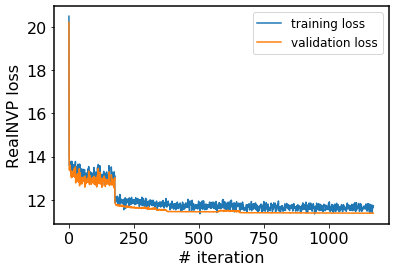

In [31]:
plt.figure()
plt.plot(nvp_tloss,label='training loss')
plt.plot(nvp_vloss,label='validation loss' )
plt.xlabel('# iteration')
plt.ylabel('RealNVP loss')
plt.legend()
plt.savefig(os.path.join(params['plot_dir'],'RealNVP_loss.pdf'),bbox_inches='tight')

In [32]:
sess.run(loss,  feed_dict={lr: learning_rate,lr: learning_rate,data:z_sample_valid})

11.385159

In [33]:
print(nvp_path)

/global/cscratch1/sd/vboehm/RNF/modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma/hybrid8_nepoch230


In [34]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
sigma         = tf.placeholder_with_default(0.1,shape=[])
sample_size   = tf.placeholder_with_default(params['batch_size'],shape=[])
data          = train_input_fn()
validdata     = eval_input_fn()
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
nvp_funcs     = hub.Module(nvp_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

prior         = get_prior(params['latent_size'])
posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params)

# inspect the model
z_      = posterior(validdata).mean()
recon   = likelihood(z_).mean()
prior_sample = prior.sample(sample_size)
x_old   = likelihood(prior_sample).mean()


nvp_sample = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample}, as_dict=True)['fwd_pass']
x_new      = likelihood(nvp_sample).mean()
 
# # ---------------------------end train nvp ----------------- #

# #comment train nvp above section above and uncomment this for loading the trained module

# #

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [36]:
rec, d = sess.run([recon,validdata])

In [37]:
x_sample = sess.run(x_old)

In [38]:
shape=params['data_shape']

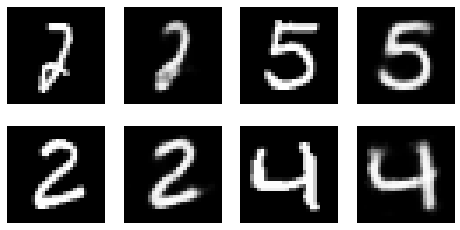

In [39]:
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(4):
    plt.subplot(2,4,jj)
    plt.imshow(np.squeeze((d[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1
    plt.subplot(2,4,jj)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1


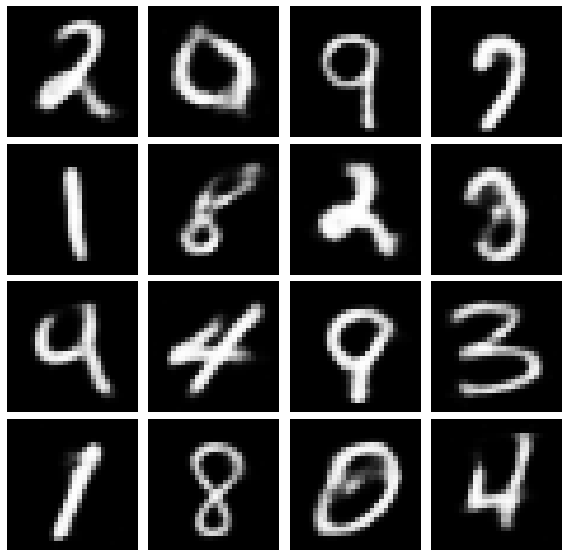

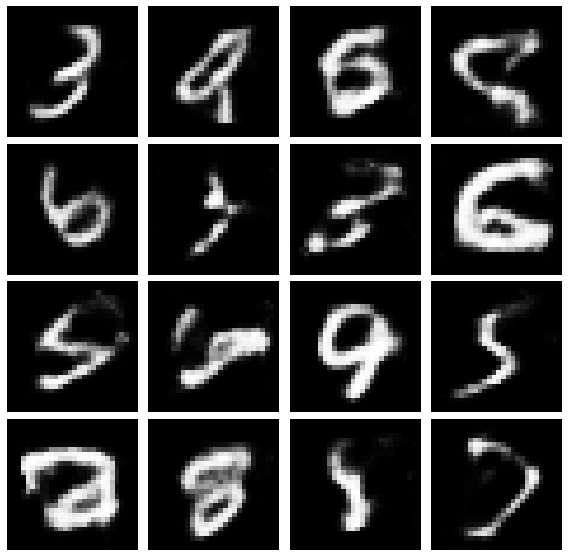

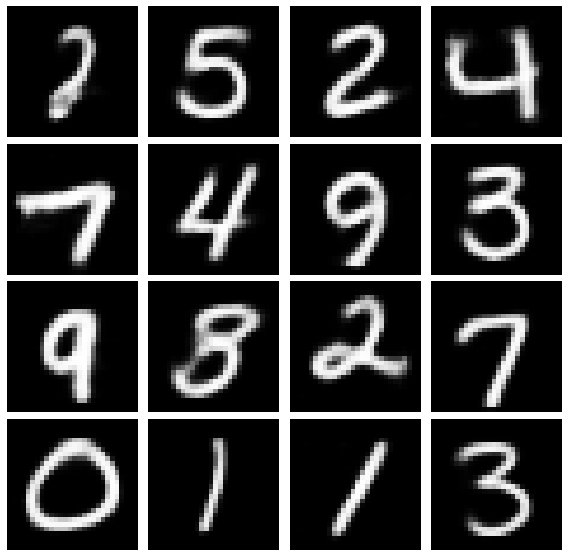

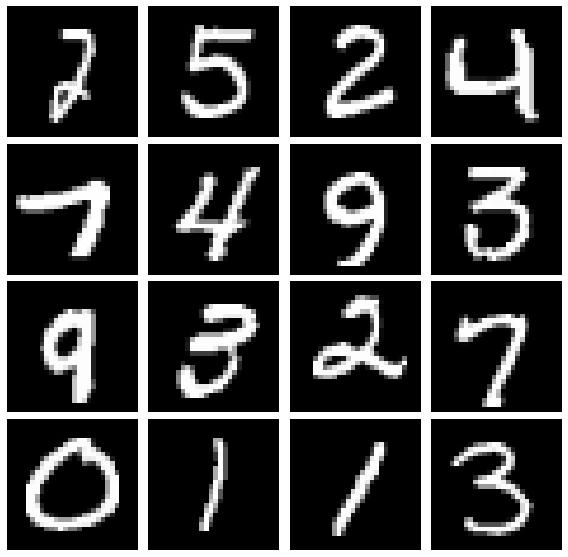

In [47]:
s_no_nvp, s_nvp = sess.run([x_old,x_new])

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((s_nvp[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'NVP_samples.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((s_no_nvp[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'reconstructions.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((d[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'inputs.pdf'),bbox_inches='tight')
plt.show()

In [41]:
z_sample_nvp = sess.run(nvp_sample,feed_dict={sample_size:10000})
print(np.amax(z_sample_nvp))
print(np.amax(z_sample))
print(np.amax(z_sample_valid))

5.429433
5.448595
4.8830476


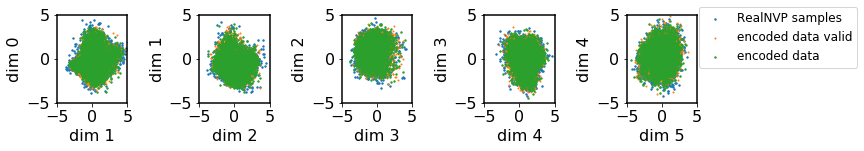

In [42]:
plt.figure(figsize=(16,16))
for nn in range(params['latent_size']-params['latent_size']//2):
    plt.subplot(8,8,nn+1)
    #plt.scatter(prior_s[:5000,nn],prior_s[:5000,nn+1],s=2, label='prior samples') 
    plt.scatter(z_sample_nvp[:5000,nn],z_sample_nvp[:5000,nn+1],s=2, label='RealNVP samples') 
    plt.scatter(z_sample_valid[:5000,nn],z_sample_valid[:5000,nn+1],s=1, label='encoded data valid')
    plt.scatter(z_sample[:5000,nn],z_sample[:5000,nn+1],s=2, label='encoded data')
    
    plt.ylabel('dim %d'%nn)
    plt.xlabel('dim %d'%(nn+1))
    plt.tight_layout()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
plt.legend(loc=(1.02,0.4))
plt.savefig(os.path.join(params['plot_dir'],'latent_space_samples.pdf'),bbox_inches='tight')

In [43]:
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))